In [10]:
# %matplotlib notebook

In [11]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv, Resnet
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from neurodiffeq.generators import Generator1D
import math
from neurodiffeq.monitors import Monitor1D
import IPython

In [12]:
alpha = 0.1

Training Progress:   0%|                              | 0/10000 [00:00<?, ?it/s]

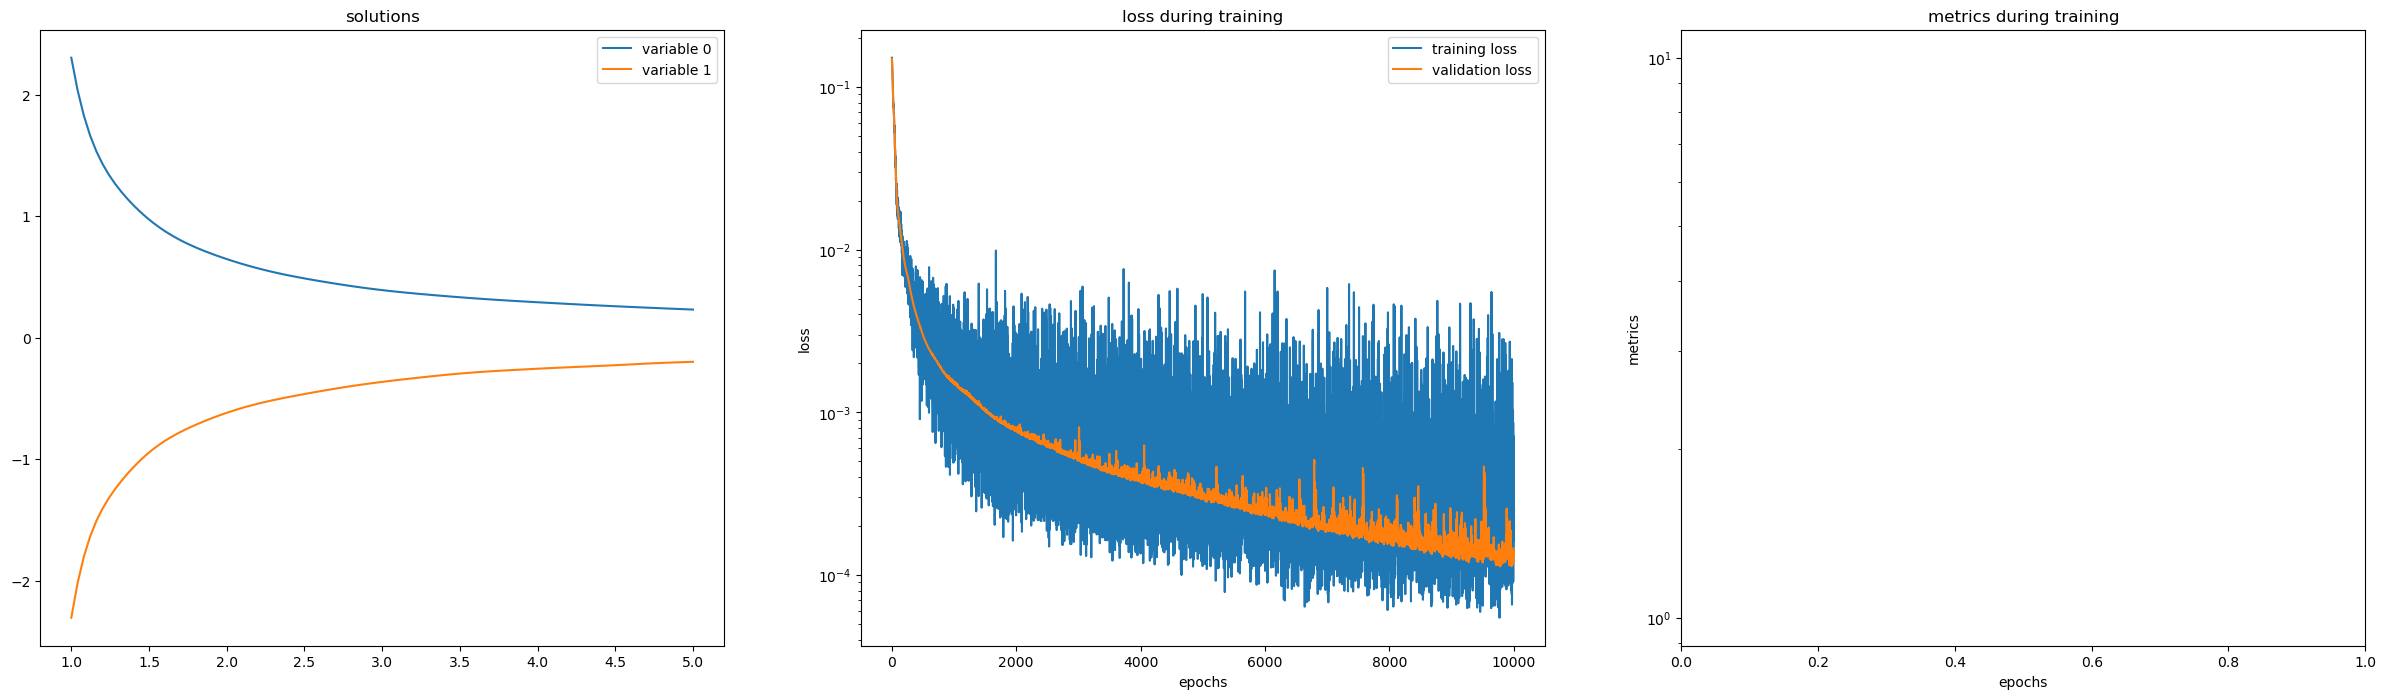

In [13]:
def ode_system(lamb, nu, t): 
    return [torch.exp(-lamb)*(diff(nu,t) + 1/t) - 1/t + alpha/torch.pow(t, 3), torch.exp(-lamb)*(diff(lamb,t) - 1/t) + 1/t - alpha/torch.pow(t, 3)]

conditions = [IVP(t_0=1.0, u_0=-np.log(alpha)), IVP(t_0=1.0, u_0=np.log(alpha))]
# conditions = [IVP(t_0=0.1, u_0=0.0), IVP(t_0=0.1, u_0=0.0)]
# g1 = Generator1D(size=64,  t_min=0.9, t_max=5.0, method='uniform') #train
# g2 = Generator1D(size=64,  t_min=0.05, t_max=0.1, method='uniform') #validate
nets = [FCNN(actv=SinActv), FCNN(actv=SinActv)]
# nets = [FCNN(actv=nn.Tanh), FCNN(actv=nn.Tanh)]
# nn.LeakyReLU
monitor = Monitor1D(t_min=1, t_max=5, check_every=10000)
# solver = Solver1D(ode_system, conditions, t_min=0.05, t_max=0.1, nets = nets, train_generator=g1, valid_generator=g2)
solver = Solver1D(ode_system, conditions, t_min=1, t_max=5, nets = nets)
solver.fit(max_epochs=10000, callbacks = [monitor.to_callback()])
solution = solver.get_solution()

In [14]:
t = np.linspace(1, 5, 10000)
lamb_nn, nu_nn = solution(t, to_numpy=True)

In [15]:
# lamb_an = np.log(t/(t-1+1/math.e))
lamb_an = - np.log(1-1/t+alpha/(t*t))
nu_an = np.log(1-1/t+alpha/(t*t))

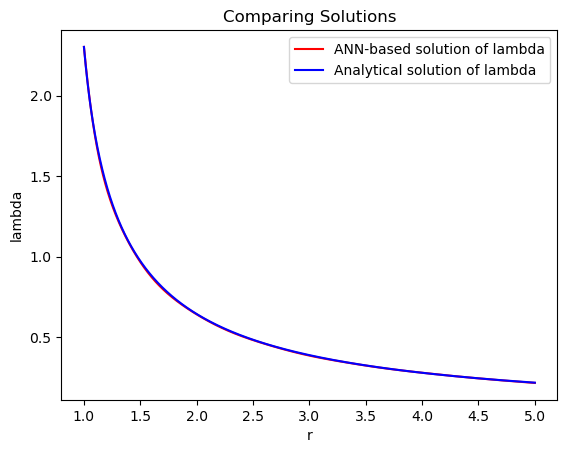

In [16]:
plt.title("Comparing Solutions")
plt.ylabel('lambda')
plt.xlabel('r')
plt.plot(t, lamb_nn, label='ANN-based solution of lambda', color = 'r')
plt.plot(t, lamb_an,label='Analytical solution of lambda', color = 'b')
plt.legend()
plt.show()

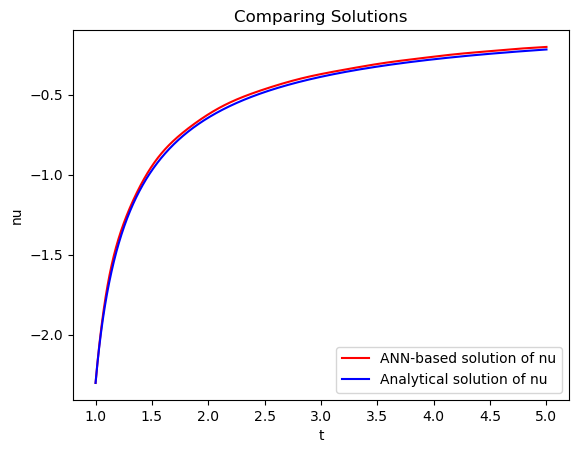

In [20]:
plt.title("Comparing Solutions")
plt.ylabel('nu')
plt.xlabel('t')
plt.plot(t, nu_nn, label='ANN-based solution of nu', color = 'r')
plt.plot(t, nu_an,label='Analytical solution of nu', color = 'b')
plt.legend()
plt.show()

In [18]:
lambda_error = np.sqrt(np.mean((lamb_nn-lamb_an)**2))
print("Mean square error in lambda is", lambda_error)

Mean square error in lambda is 0.004361456525811802


In [19]:
nu_error = np.sqrt(np.mean((nu_nn-nu_an)**2))
print("Mean square error in nu is", nu_error)

Mean square error in nu is 0.01950685272070772


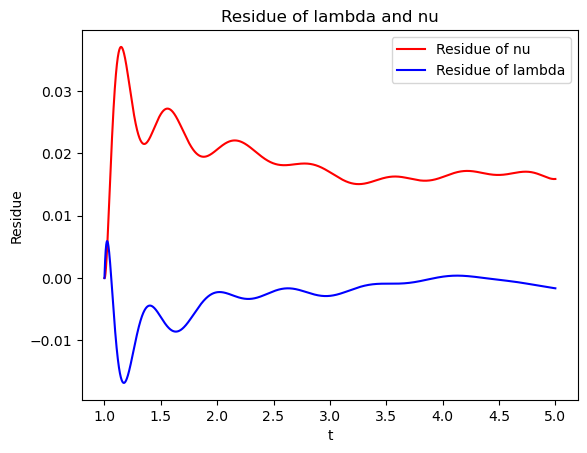

In [21]:
plt.title("Residue of lambda and nu")
plt.ylabel('Residue')
plt.xlabel('t')
plt.plot(t, nu_nn-nu_an, label='Residue of nu', color = 'r')
plt.plot(t, lamb_nn-lamb_an,label='Residue of lambda', color = 'b')
plt.legend()
plt.savefig('RNResidue')
plt.show()